In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm

from multiprocessing import Pool, cpu_count

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras.callbacks import LambdaCallback, EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
df_train = pd.read_csv('inputs/train_v2.csv')
df_train.head(2)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water


In [4]:
def get_labels():
    labels = [
        'slash_burn',
        'clear',
        'blooming',
        'primary',
        'cloudy',
        'conventional_mine',
        'water',
        'haze',
        'cultivation',
        'partly_cloudy',
        'artisinal_mine',
        'habitation',
        'bare_ground',
        'blow_down',
        'agriculture',
        'road',
        'selective_logging'
    ]

    l_map = {l: i for i, l in enumerate(labels)}
    inv_map = {i: l for l, i in l_map.items()}
    return labels, l_map, inv_map

labels, label_map, inv_label_map = get_labels()
print(labels)

['slash_burn', 'clear', 'blooming', 'primary', 'cloudy', 'conventional_mine', 'water', 'haze', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'blow_down', 'agriculture', 'road', 'selective_logging']


In [5]:
input_dir = 'inputs'
img_size = 256

X = []
Y = []
for f, tags in tqdm(df_train.sample(1000).values, miniters=1000):
    f_name = '{}.jpg'.format(f)
#     print(os.path.join(input_dir, 'train-jpg', f_name))
    img = cv2.imread(os.path.join(input_dir, 'train-jpg', f_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    X.append(cv2.resize(img, (img_size, img_size)))
    Y.append(targets)

X = np.array(X, np.float16) / 255.
Y = np.array(Y, np.uint8)

print(X.shape)
print(Y.shape)

100%|██████████| 1000/1000 [00:03<00:00, 288.39it/s]


(1000, 256, 256, 3)
(1000, 17)


In [6]:
from keras import applications
# model = applications.Xception(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, 3), pooling='avg')
model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape = (img_size, img_size, 3))

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 127, 127, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 127, 127, 32)  96                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 127, 127, 32)  0                                            
___________________________________________________________________________________________

activation_12 (Activation)       (None, 29, 29, 32)    0                                            
____________________________________________________________________________________________________
mixed0 (Concatenate)             (None, 29, 29, 256)   0                                            
____________________________________________________________________________________________________
conv2d_16 (Conv2D)               (None, 29, 29, 64)    16384                                        
____________________________________________________________________________________________________
batch_normalization_16 (BatchNor (None, 29, 29, 64)    192                                          
____________________________________________________________________________________________________
activation_16 (Activation)       (None, 29, 29, 64)    0                                            
___________________________________________________________________________________________

____________________________________________________________________________________________________
batch_normalization_25 (BatchNor (None, 29, 29, 96)    288                                          
____________________________________________________________________________________________________
batch_normalization_26 (BatchNor (None, 29, 29, 64)    192                                          
____________________________________________________________________________________________________
activation_20 (Activation)       (None, 29, 29, 64)    0                                            
____________________________________________________________________________________________________
activation_22 (Activation)       (None, 29, 29, 64)    0                                            
____________________________________________________________________________________________________
activation_25 (Activation)       (None, 29, 29, 96)    0                                   

conv2d_31 (Conv2D)               (None, 14, 14, 192)   147456                                       
____________________________________________________________________________________________________
conv2d_34 (Conv2D)               (None, 14, 14, 192)   172032                                       
____________________________________________________________________________________________________
conv2d_39 (Conv2D)               (None, 14, 14, 192)   172032                                       
____________________________________________________________________________________________________
conv2d_40 (Conv2D)               (None, 14, 14, 192)   147456                                       
____________________________________________________________________________________________________
batch_normalization_31 (BatchNor (None, 14, 14, 192)   576                                          
___________________________________________________________________________________________

____________________________________________________________________________________________________
activation_44 (Activation)       (None, 14, 14, 192)   0                                            
____________________________________________________________________________________________________
activation_49 (Activation)       (None, 14, 14, 192)   0                                            
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 14, 14, 192)   0                                            
____________________________________________________________________________________________________
mixed5 (Concatenate)             (None, 14, 14, 768)   0                                            
____________________________________________________________________________________________________
conv2d_55 (Conv2D)               (None, 14, 14, 160)   122880                              

batch_normalization_66 (BatchNor (None, 14, 14, 192)   576                                          
____________________________________________________________________________________________________
activation_66 (Activation)       (None, 14, 14, 192)   0                                            
____________________________________________________________________________________________________
conv2d_62 (Conv2D)               (None, 14, 14, 192)   147456                                       
____________________________________________________________________________________________________
conv2d_67 (Conv2D)               (None, 14, 14, 192)   258048                                       
____________________________________________________________________________________________________
batch_normalization_62 (BatchNor (None, 14, 14, 192)   576                                          
___________________________________________________________________________________________

____________________________________________________________________________________________________
conv2d_76 (Conv2D)               (None, 6, 6, 192)     331776                                       
____________________________________________________________________________________________________
batch_normalization_72 (BatchNor (None, 6, 6, 320)     960                                          
____________________________________________________________________________________________________
batch_normalization_76 (BatchNor (None, 6, 6, 192)     576                                          
____________________________________________________________________________________________________
activation_72 (Activation)       (None, 6, 6, 320)     0                                            
____________________________________________________________________________________________________
activation_76 (Activation)       (None, 6, 6, 192)     0                                   

activation_90 (Activation)       (None, 6, 6, 448)     0                                            
____________________________________________________________________________________________________
conv2d_87 (Conv2D)               (None, 6, 6, 384)     786432                                       
____________________________________________________________________________________________________
conv2d_91 (Conv2D)               (None, 6, 6, 384)     1548288                                      
____________________________________________________________________________________________________
batch_normalization_87 (BatchNor (None, 6, 6, 384)     1152                                         
____________________________________________________________________________________________________
batch_normalization_91 (BatchNor (None, 6, 6, 384)     1152                                         
___________________________________________________________________________________________

In [8]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2)

In [9]:
from keras.layers import Concatenate
concats = []
for i, l in enumerate(model.layers):
    if type(l) is Concatenate:
        concats.append(i)
concats

[40, 63, 86, 100, 132, 164, 196, 228, 248, 276, 277, 279, 307, 308, 310]

In [10]:
for l in model.layers[:concats[0]]:
    l.trainable = False

In [11]:
if img_size == 256:
    pool_size = 3
else:
    pool_size = 2

In [17]:
model.input.shape[1] == 256

True

In [24]:
#Adding classifier
x = model.output
x = MaxPooling2D(pool_size=pool_size)(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(17, activation="sigmoid")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = x)
model_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model_final.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 127, 127, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 127, 127, 32)  96                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 127, 127, 32)  0                                            
___________________________________________________________________________________________

____________________________________________________________________________________________________
batch_normalization_25 (BatchNor (None, 29, 29, 96)    288                                          
____________________________________________________________________________________________________
batch_normalization_26 (BatchNor (None, 29, 29, 64)    192                                          
____________________________________________________________________________________________________
activation_20 (Activation)       (None, 29, 29, 64)    0                                            
____________________________________________________________________________________________________
activation_22 (Activation)       (None, 29, 29, 64)    0                                            
____________________________________________________________________________________________________
activation_25 (Activation)       (None, 29, 29, 96)    0                                   

____________________________________________________________________________________________________
activation_44 (Activation)       (None, 14, 14, 192)   0                                            
____________________________________________________________________________________________________
activation_49 (Activation)       (None, 14, 14, 192)   0                                            
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 14, 14, 192)   0                                            
____________________________________________________________________________________________________
mixed5 (Concatenate)             (None, 14, 14, 768)   0                                            
____________________________________________________________________________________________________
conv2d_55 (Conv2D)               (None, 14, 14, 160)   122880                              

____________________________________________________________________________________________________
conv2d_76 (Conv2D)               (None, 6, 6, 192)     331776                                       
____________________________________________________________________________________________________
batch_normalization_72 (BatchNor (None, 6, 6, 320)     960                                          
____________________________________________________________________________________________________
batch_normalization_76 (BatchNor (None, 6, 6, 192)     576                                          
____________________________________________________________________________________________________
activation_72 (Activation)       (None, 6, 6, 320)     0                                            
____________________________________________________________________________________________________
activation_76 (Activation)       (None, 6, 6, 192)     0                                   

In [27]:
np.random.seed(0)
scores = []
batch_size = 256
epochs = 10

def my_callback_func(batch,logs):
    p_valid = model_final.predict(X_valid, batch_size=batch_size,verbose=2)
    score = fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples')
    scores.append(score)


my_callback = LambdaCallback(on_epoch_end=lambda batch,logs: my_callback_func(batch,logs))
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0)
callbacks = [my_callback, early_stop]
# callbacks = [my_callback]

history_callback = model_final.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=2,
          validation_data=(X_valid, Y_valid), callbacks=callbacks)

print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))

Train on 800 samples, validate on 200 samples
Epoch 1/10


KeyboardInterrupt: 

Max score 0.891111 at epoch 9


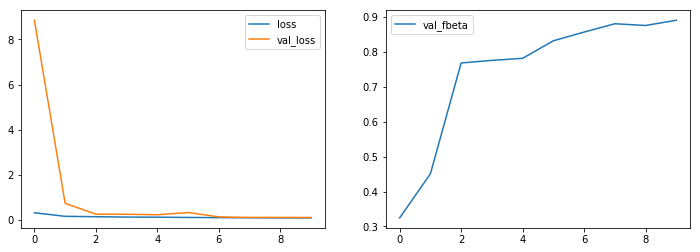

In [63]:
print("Max score %f at epoch %d" % (np.max(scores), np.argmax(scores)))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_callback.history['loss'])
plt.plot(history_callback.history['val_loss'])
plt.legend(labels=['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(scores)
plt.legend(labels=['val_fbeta'])
plt.show()